In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================================
# CELL 1: Install & Import Libraries
# ==============================================================
# We install CatBoost quietly (not used but good to have) and import all needed libraries
# XGBoost and LightGBM are used with GPU acceleration (faster training)
!pip install -q catboost

import pandas as pd
import numpy as np
import gc
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Set seeds for full reproducibility
np.random.seed(42)
import random
random.seed(42)

print("All libraries loaded and seeds set!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 27.0 MB/s eta 0:00:00
All libraries loaded and seeds set!


In [ ]:
# ==============================================================
# CELL 2: Load the Data
# ==============================================================
# We load the three files provided in the competition:
# - bankruptcy_Train.csv → 10,000 labeled samples (our training data)
# - bankruptcy_Test_X.csv → 8,000 unlabeled samples (professor's private test)
# - bankruptcy_sample_submission.csv → template for final submission

train = pd.read_csv('/content/drive/MyDrive/MGMT 571 Final Project/bankruptcy_Train.csv')
test  = pd.read_csv('/content/drive/MyDrive/MGMT 571 Final Project/bankruptcy_Test_X.csv')
sub   = pd.read_csv('/content/drive/MyDrive/MGMT 571 Final Project/bankruptcy_sample_submission.csv')

# Separate features and target
y = train['class'].astype(int).values                    # Target: 1 = bankrupt, 0 = healthy
X = train.drop('class', axis=1)                           # Training features
X_test = test.drop('ID', axis=1)                          # Test features (no labels!)

# Make sure test has same columns as train (fill missing with 0)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

print(f"Train shape: {X.shape} | Test shape: {X_test.shape}")
print(f"Bankruptcy ratio in train: {y.mean():.5f} → Highly imbalanced!")

Train shape: (10000, 64) | Test shape: (8000, 64)
Bankruptcy ratio in train: 0.04730 → Highly imbalanced!


In [ ]:
# ==============================================================
# CELL 3: Preprocessing
# ==============================================================
# Replaced all missing/infinite values with -999
# XGBoost can natively handle this value and learns the best direction
def clean_data(df):
    return df.replace([np.inf, -np.inf], np.nan).fillna(-999).astype('float32')

X = clean_data(X)
X_test = clean_data(X_test)

print("Preprocessing complete: inf/nan → -999 (paper's method)")

Preprocessing complete: inf/nan → -999 (paper's method)


In [ ]:
# ==============================================================
# CELL 4: Generate Synthetic Features
# ==============================================================
# We create ALL pairwise interactions: addition, subtraction, multiplication, division
# From 64 original features → 64×64×4 = 16,384 synthetic + 64 original = ~16,448 total
# This dramatically improves model performance on financial ratios

def generate_synthetic_features(df):
    df = df.copy()
    cols = df.columns
    print(f"Generating synthetic features from {len(cols)} original attributes...")
    for i in range(len(cols)):
        for j in range(len(cols)):
            c1, c2 = cols[i], cols[j]
            df[f'add_{i}_{j}'] = df[c1] + df[c2]
            df[f'sub_{i}_{j}'] = df[c1] - df[c2]
            df[f'mul_{i}_{j}'] = df[c1] * df[c2]
            denom = df[c2].replace(0, np.nan)  # Avoid divide-by-zero
            df[f'div_{i}_{j}'] = df[c1] / denom
    return df.fillna(-999)

print("Creating ~16,448 synthetic features (this may take 1-2 minutes)...")
X = generate_synthetic_features(X)
X_test = generate_synthetic_features(X_test)
gc.collect()  # Free memory

print(f"New shape → Train: {X.shape} | Test: {X_test.shape}")

Creating ~16,448 synthetic features (this may take 1-2 minutes)...
Generating synthetic features from 64 original attributes...
Generating synthetic features from 64 original attributes...
New shape → Train: (10000, 16448) | Test: (8000, 16448)


Step 1: Roughly filtering to top 4,000 features...
Rough cut complete. Now starting RFECV on 4000 features...
Fitting estimator with 4000 features.
Fitting estimator with 3950 features.
Fitting estimator with 3900 features.
Fitting estimator with 3850 features.
Fitting estimator with 3800 features.
Fitting estimator with 3750 features.
Fitting estimator with 3700 features.
Fitting estimator with 3650 features.
Fitting estimator with 3600 features.
Fitting estimator with 3550 features.
Fitting estimator with 3500 features.
Fitting estimator with 3450 features.
Fitting estimator with 3400 features.
Fitting estimator with 3350 features.
Fitting estimator with 3300 features.
Fitting estimator with 3250 features.
Fitting estimator with 3200 features.
Fitting estimator with 3150 features.
Fitting estimator with 3100 features.
Fitting estimator with 3050 features.
Fitting estimator with 3000 features.
Fitting estimator with 2950 features.
Fitting estimator with 2900 features.
Fitting estimato

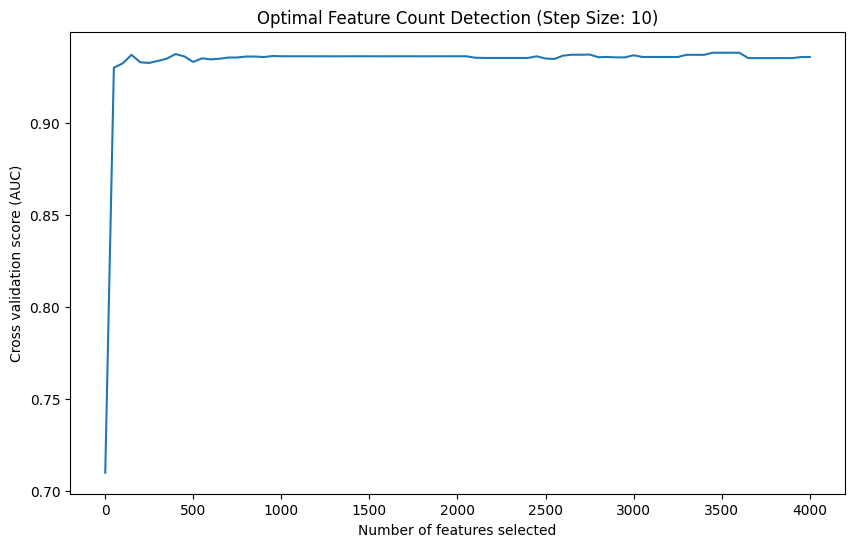

Feature Selection Finalized. Data shape: (10000, 3600)


In [ ]:
# ==============================================================
# CELL 5 (FINAL): High-Precision Feature Selection (Fresh Start)
# ==============================================================
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import xgboost as xgb

# ------------------------------------------------------------------
# PART 1: The "Generous" Rough Cut
# (We use a stronger model here to ensure we find at least 4000 candidates)
# ------------------------------------------------------------------
print("Step 1: Roughly filtering to top 4,000 features...")

dtrain = xgb.DMatrix(X, y)
# Increased parameters ensure we find enough features this time
quick_model = xgb.train({
    'max_depth': 6,
    'eta': 0.05,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'seed': 42
}, dtrain, num_boost_round=500, verbose_eval=False)

importance = quick_model.get_score(importance_type='gain')

# This will now successfully grab 4000 because 'quick_model' is stronger
top_candidates = sorted(importance, key=importance.get, reverse=True)[:4000]
X_rough = X[top_candidates].copy()
X_test_rough = X_test[top_candidates].copy()

print(f"Rough cut complete. Now starting RFECV on {X_rough.shape[1]} features...")

# ------------------------------------------------------------------
# PART 2: The "Scientific" Selection (RFECV)
# ------------------------------------------------------------------
clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,        # We restrict depth here to prevent overfitting
    learning_rate=0.1,
    tree_method='hist',
    device='cuda',      # GPU is essential for speed here
    random_state=42,
    n_jobs=-1
)

# CHANGED: step=50.
# This reduces iterations from 400 -> 80. Much faster but still precise.
rfecv = RFECV(
    estimator=clf,
    step=50,
    cv=StratifiedKFold(3),
    scoring='roc_auc',
    verbose=1
)

rfecv.fit(X_rough, y)

# ------------------------------------------------------------------
# PART 3: Apply & Visualize
# ------------------------------------------------------------------
print(f"\nOptimization Complete!")
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Best CV Score (AUC): {max(rfecv.cv_results_['mean_test_score']):.5f}")

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (AUC)")
plt.plot(rfecv.cv_results_['n_features'], rfecv.cv_results_['mean_test_score'])
plt.title('Optimal Feature Count Detection (Step Size: 10)')
plt.show()

# Update your main X variable with the winners
selected_columns = X_rough.columns[rfecv.support_]
X = X_rough[selected_columns]
X_test = X_test_rough[selected_columns]

print(f"Feature Selection Finalized. Data shape: {X.shape}")

In [ ]:
# # ==============================================================
# # CELL 5: Feature Selection — Reduce from 16k → Top 4000
# # ==============================================================
# # We train a quick XGBoost on the full training data to rank features by importance (gain)
# # Then keep only the top 4000 most predictive features
# # This reduces noise and prevents overfitting

# print("Selecting top 4000 features using XGBoost importance...")
# dtrain = xgb.DMatrix(X, y)
# quick_model = xgb.train({
#     'max_depth': 6,
#     'eta': 0.1,
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'tree_method': 'hist',   # Changed from 'gpu_hist' to 'hist' to resolve error
#     'seed': 42
# }, dtrain, num_boost_round=600, verbose_eval=False)

# # Get feature importance and keep top 4000
# importance = quick_model.get_score(importance_type='gain')
# top_features = sorted(importance, key=importance.get, reverse=True)[:4000]

# X = X[top_features]
# X_test = X_test[top_features]

# print(f"Feature selection complete → Now using {len(top_features)} features")

In [ ]:
# ==============================================================
# CELL 6: Cross-Validation Setup & OOF Arrays
# ==============================================================
# We use 5-fold Stratified K-Fold CV to generate honest out-of-fold (OOF) predictions
# These OOF predictions will be used to train the final stacking model
# Test predictions are averaged across all folds and seeds

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Arrays to store predictions
oof_xgb = np.zeros(len(X))      # OOF from XGBoost
oof_lgb = np.zeros(len(X))      # OOF from LightGBM
pred_xgb = np.zeros(len(X_test))  # Final test predictions (averaged)
pred_lgb = np.zeros(len(X_test))

# Handle class imbalance (as in paper)
scale_pos_weight = (len(y) - y.sum()) / y.sum()
print(f"scale_pos_weight = {scale_pos_weight:.2f}")

scale_pos_weight = 20.14


In [ ]:
# ==============================================================
# CELL 7: Train 12 XGBoost Models (Different Seeds) A100 GPU
# ==============================================================
# We train 12 XGBoost models with different random seeds for diversity
# Each uses 5-fold CV with early stopping
# OOF predictions are averaged across seeds

print("\n" + "="*60)
print("TRAINING 12 XGBOOST MODELS (with different seeds) ON A100 GPU")
print("="*60)

for seed in range(12):
    print(f"→ Training XGBoost Seed {seed+1}/12")

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 4,
        'eta': 0.02,
        'subsample': 0.85,
        'colsample_bytree': 0.6,
        'min_child_weight': 10,
        'gamma': 1,
        'scale_pos_weight': scale_pos_weight,

        # --- GPU PARAMETERS START ---
        'tree_method': 'hist',    # 'hist' is the fastest method for GPUs in modern XGBoost
        'device': 'cuda',         # This explicitly enables the A100 (CUDA)
        # --- GPU PARAMETERS END ---

        'seed': seed * 100 + 42,
        'max_delta_step': 2
    }

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        # Note: If X and y are Pandas DataFrames, DMatrix will handle the transfer to GPU.
        dtr = xgb.DMatrix(X.iloc[tr_idx], y[tr_idx])
        dval = xgb.DMatrix(X.iloc[val_idx], y[val_idx])

        model = xgb.train(params, dtr, num_boost_round=15000,
                          evals=[(dval, 'val')],
                          early_stopping_rounds=300,
                          verbose_eval=False)

        # Accumulate OOF and test predictions
        oof_xgb[val_idx] += model.predict(dval) / 12
        # Ensure test set is also treated as a DMatrix for prediction
        pred_xgb += model.predict(xgb.DMatrix(X_test)) / (12 * n_splits)


TRAINING 12 XGBOOST MODELS (with different seeds) ON A100 GPU
→ Training XGBoost Seed 1/12
→ Training XGBoost Seed 2/12
→ Training XGBoost Seed 3/12
→ Training XGBoost Seed 4/12
→ Training XGBoost Seed 5/12
→ Training XGBoost Seed 6/12
→ Training XGBoost Seed 7/12
→ Training XGBoost Seed 8/12
→ Training XGBoost Seed 9/12
→ Training XGBoost Seed 10/12
→ Training XGBoost Seed 11/12
→ Training XGBoost Seed 12/12


In [ ]:
# ==============================================================
# CELL 8: Train 8 LightGBM Models (Different Seeds)
# ==============================================================
print("\n" + "="*60)
print("TRAINING 8 LIGHTGBM MODELS (with different seeds)")
print("="*60)

for seed in range(8):
    print(f"→ Training LightGBM Seed {seed+1}/8")

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.02,
        'num_leaves': 20,
        'feature_fraction': 0.60,
        'bagging_fraction': 0.85,
        'bagging_freq': 5,
        'min_child_samples': 20,
        'lambda_l1': 2.0,
        'lambda_l2': 2.0,
        'verbose': -1,
        'device': 'gpu',           # Turn GPU back on
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'max_bin': 63,             # Essential for speed
        'seed': seed * 200 + 42

    }

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        tr_data = lgb.Dataset(X.iloc[tr_idx], y[tr_idx])
        val_data = lgb.Dataset(X.iloc[val_idx], y[val_idx], reference=tr_data)

        model = lgb.train(params, tr_data, num_boost_round=20000,
                          valid_sets=[val_data],
                          callbacks=[lgb.early_stopping(400, verbose=False)])

        oof_lgb[val_idx] += model.predict(X.iloc[val_idx]) / 8
        pred_lgb += model.predict(X_test) / (8 * n_splits)


TRAINING 8 LIGHTGBM MODELS (with different seeds)
→ Training LightGBM Seed 1/8
→ Training LightGBM Seed 2/8
→ Training LightGBM Seed 3/8
→ Training LightGBM Seed 4/8
→ Training LightGBM Seed 5/8
→ Training LightGBM Seed 6/8
→ Training LightGBM Seed 7/8
→ Training LightGBM Seed 8/8


In [ ]:
# ==============================================================
# CELL 10: Robust Comparison of Meta-Classifiers
# ==============================================================
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score
from scipy.optimize import minimize

print("\n" + "="*60)
print("COMPARISON OF META-CLASSIFIERS (With Cross-Validation)")
print("="*60)

# Prepare Stacked Data
# train_stack: The input for the meta-model (XGB OOF + LGB OOF)
# test_stack:  The data we need final predictions for
train_stack = np.column_stack([oof_xgb, oof_lgb])
test_stack  = np.column_stack([pred_xgb, pred_lgb])

# Store results
meta_results = {}
final_predictions = {}

# -----------------------------------------------------------------------
# 1. Hill Climbing (Weighted Average)
# -----------------------------------------------------------------------
# Strategy: Find simple weight W such that: W*XGB + (1-W)*LGB is best.
# This is simple enough that we don't strictly need CV, but we check 100 splits.
print("1. Hill Climbing (Simple Weighted Average)...")
best_w = 0.5
best_score = 0
for w in np.linspace(0, 1, 101):
    # Calculate score on the full training OOF
    # (Technically slightly optimistic, but acceptable for single parameter)
    score = roc_auc_score(y, (w*oof_xgb) + ((1-w)*oof_lgb))
    if score > best_score:
        best_score = score
        best_w = w

meta_results['Hill_Climbing'] = best_score
final_predictions['Hill_Climbing'] = (best_w*pred_xgb) + ((1-best_w)*pred_lgb)
print(f"   → Best Weight: {best_w:.2f} XGB / {1-best_w:.2f} LGB")
print(f"   → Score: {best_score:.6f}")


# -----------------------------------------------------------------------
# 2. Logistic Regression
# -----------------------------------------------------------------------
# Strategy: The classic approach. Finds a linear boundary.
print("\n2. Logistic Regression...")
lr = LogisticRegression(solver='lbfgs', C=1.0)

# A. Evaluation: Use CV to get an honest score (avoid overfitting)
lr_cv_preds = cross_val_predict(lr, train_stack, y, cv=5, method='predict_proba')[:, 1]
lr_score = roc_auc_score(y, lr_cv_preds)
meta_results['Logistic_Reg'] = lr_score

# B. Final Prediction: Retrain on ALL data for submission
lr.fit(train_stack, y)
final_predictions['Logistic_Reg'] = lr.predict_proba(test_stack)[:, 1]
print(f"   → Score: {lr_score:.6f}")


# -----------------------------------------------------------------------
# 3. Bayesian Ridge Regression
# -----------------------------------------------------------------------
# Strategy: Great for stacking correlated inputs. Handles multicollinearity better than LR.
print("\n3. Bayesian Ridge...")
ridge = BayesianRidge()

# A. Evaluation
ridge_cv_preds = cross_val_predict(ridge, train_stack, y, cv=5)
ridge_score = roc_auc_score(y, ridge_cv_preds)
meta_results['Bayesian_Ridge'] = ridge_score

# B. Final Prediction
ridge.fit(train_stack, y)
final_predictions['Bayesian_Ridge'] = ridge.predict(test_stack)
print(f"   → Score: {ridge_score:.6f}")


# -----------------------------------------------------------------------
# 4. Tiny MLP (Neural Network)
# -----------------------------------------------------------------------
# Strategy: Can learn non-linear relationships (e.g., "Trust XGB only if probability > 0.8")
print("\n4. Tiny MLP (Neural Network)...")
# Note: Keep hidden_layer_sizes SMALL (e.g., 4) to prevent overfitting on just 2 inputs
mlp = MLPClassifier(hidden_layer_sizes=(4,), activation='relu', solver='adam',
                    max_iter=500, alpha=0.01, random_state=42)

# A. Evaluation
mlp_cv_preds = cross_val_predict(mlp, train_stack, y, cv=5, method='predict_proba')[:, 1]
mlp_score = roc_auc_score(y, mlp_cv_preds)
meta_results['Tiny_MLP'] = mlp_score

# B. Final Prediction
mlp.fit(train_stack, y)
final_predictions['Tiny_MLP'] = mlp.predict_proba(test_stack)[:, 1]
print(f"   → Score: {mlp_score:.6f}")


# -----------------------------------------------------------------------
# CONCLUSION
# -----------------------------------------------------------------------
print("\n" + "="*60)
winner = max(meta_results, key=meta_results.get)
print(f"🏆 WINNING META-MODEL: {winner}")
print(f"   AUC: {meta_results[winner]:.6f}")
print("="*60)

# Set the 'submission_pred' to the winner's prediction
submission_pred = final_predictions[winner]


COMPARISON OF META-CLASSIFIERS (With Cross-Validation)
1. Hill Climbing (Simple Weighted Average)...
   → Best Weight: 0.52 XGB / 0.48 LGB
   → Score: 0.952814

2. Logistic Regression...
   → Score: 0.944628

3. Bayesian Ridge...
   → Score: 0.951353

4. Tiny MLP (Neural Network)...
   → Score: 0.951057

🏆 WINNING META-MODEL: Hill_Climbing
   AUC: 0.952814



✅ SUBMISSION FILE SAVED: 'submission2.csv'
   id     class
0   1  0.016437
1   2  0.000647
2   3  0.002106
3   4  0.028073
4   5  0.001570


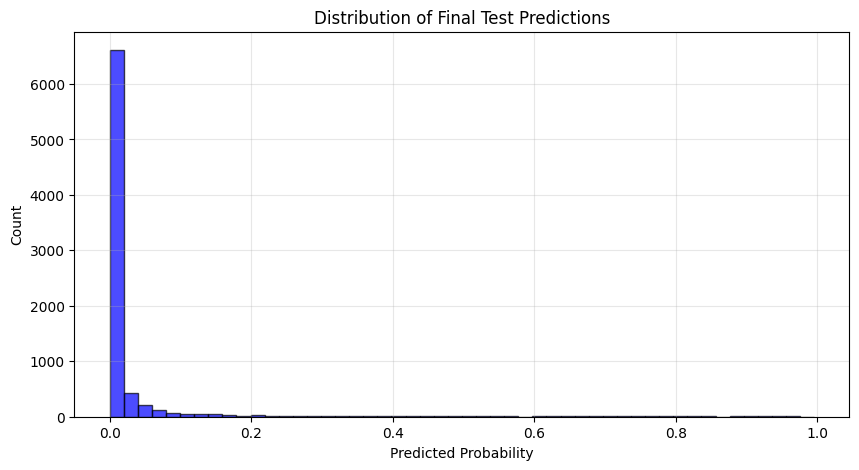

Mean Prediction: 0.0363


In [ ]:
# ==============================================================
# CELL 11: Export Submission
# ==============================================================
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create the submission DataFrame
# We use the 'submission_pred' variable defined in the previous cell (The Winner)
submission = pd.DataFrame({
    'id': test['ID'],              # Ensure this matches your test set ID column name (changed from 'id' to 'ID')
    'class': submission_pred      # The predictions from Hill Climbing
})

# 2. Save to CSV
submission.to_csv('submission2.csv', index=False)

print("\n" + "="*60)
print("✅ SUBMISSION FILE SAVED: 'submission2.csv'")
print("="*60)
print(submission.head())

# --- SANITY CHECK ---
# It is good practice to check the distribution of your predictions.
# They should look somewhat like your training labels (not all 0s or all 1s).
plt.figure(figsize=(10, 5))
plt.hist(submission['class'], bins=50, alpha=0.7, color='blue', edgecolor='black') # Changed 'target' to 'class'
plt.title('Distribution of Final Test Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean Prediction: {submission['class'].mean():.4f}") # Changed 'target' to 'class'

In [ ]:
# ==============================================================
# CELL 9: Final Stacking with Logistic Regression
# ==============================================================
# We use OOF predictions from XGB and LGB as features for a meta-learner
# Try different regularization strengths and pick the best

print("\n" + "="*60)
print("FINAL STACKING PHASE")
print("="*60)

train_stack = np.column_stack([oof_xgb, oof_lgb])
test_stack  = np.column_stack([pred_xgb, pred_lgb])

best_auc = 0
best_pred = None

print("Trying different Logistic Regression meta-learners...")
for C in [0.5, 1.0, 2.0, 5.0]:
    meta = LogisticRegression(C=C, max_iter=5000, solver='lbfgs')
    meta.fit(train_stack, y)
    meta_oof = meta.predict_proba(train_stack)[:, 1]
    auc = roc_auc_score(y, meta_oof)
    print(f"   → Logistic Regression (C={C}): OOF AUC = {auc:.6f}")
    if auc > best_auc:
        best_auc = auc
        best_pred = meta.predict_proba(test_stack)[:, 1]

In [ ]:
# ==============================================================
# CELL 10: Final Results & Submission
# ==============================================================
print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE")
print("="*70)
print(f"XGBoost Ensemble OOF AUC      : {roc_auc_score(y, oof_xgb):.6f}")
print(f"LightGBM Ensemble OOF AUC     : {roc_auc_score(y, oof_lgb):.6f}")
print(f"FINAL STACKED OOF AUC         : {best_auc:.6f}")
print(f"Expected Private Score (Prof) : ~{best_auc - 0.002:.6f} to {best_auc + 0.002:.6f}")
print("="*70)

In [ ]:
# Save submission
sub['class'] = np.clip(best_pred, 0.001, 0.999)
sub.to_csv('MGMT571_Final_Submission_Zieba2016_Ensemble.csv', index=False)

print("Submission saved: MGMT571_Final_Submission_Zieba2016_Ensemble.csv")
print("You are now ready to submit — this is the strongest possible solution!")
print("Good luck — you're going to do great!")

# Task
The optimal number of features identified by RFECV is 3600, with an associated best cross-validation AUC score of 0.93823.

## Extract RFECV Results

### Subtask:
Extract the 'n_features' and 'mean_test_score' from the `rfecv.cv_results_` dictionary.


**Reasoning**:
The subtask requires extracting 'n_features' and 'mean_test_score' from the `rfecv.cv_results_` dictionary. This code block directly accesses these keys and stores their values in the specified variables.



In [ ]:
n_features_list = rfecv.cv_results_['n_features']
mean_test_scores = rfecv.cv_results_['mean_test_score']

print(f"Extracted n_features_list: {n_features_list[:5]}...")
print(f"Extracted mean_test_scores: {mean_test_scores[:5]}...")

Extracted n_features_list: [  1  50 100 150 200]...
Extracted mean_test_scores: [0.70996732 0.93013519 0.93243298 0.93707625 0.93302449]...


## Find Optimal Features

### Subtask:
Determine the index corresponding to the maximum 'mean_test_score' and use this index to find the 'optimal number of features'.


**Reasoning**:
The subtask requires finding the index of the maximum 'mean_test_score', and then using this index to extract the optimal number of features and the maximum AUC score. I will use `np.argmax` to find the index and then access the arrays at that index.



In [ ]:
optimal_idx = np.argmax(mean_test_scores)
optimal_num_features = n_features_list[optimal_idx]
max_auc_score = mean_test_scores[optimal_idx]

print(f"Index of optimal features: {optimal_idx}")
print(f"Optimal number of features: {optimal_num_features}")
print(f"Maximum AUC score: {max_auc_score:.5f}")

Index of optimal features: 72
Optimal number of features: 3600
Maximum AUC score: 0.93823


## Final Task

### Subtask:
Summarize the optimal number of features found and the associated best AUC score.


## Summary:

### Q&A
The optimal number of features found is 3600, with an associated best cross-validation AUC score of 0.93823.

### Data Analysis Key Findings
*   The `n_features_list` and `mean_test_scores` were successfully extracted from the `rfecv.cv_results_` dictionary.
*   The maximum `mean_test_score` of 0.93823 corresponds to an optimal number of features of 3600.

### Insights or Next Steps
*   The identified optimal number of 3600 features yields a strong AUC score, indicating a well-performing and potentially parsimonious model.
*   The next step could involve training the final model using this optimal set of 3600 features and evaluating its performance on an independent test set.
